<a href="https://colab.research.google.com/github/iamsahan/HumanActionDetection-SE4050/blob/DenseNet201/DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Imports

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Unzip your dataset (make sure you have the dataset.zip file)
!unzip '/content/drive/MyDrive/DL Assignment/datasets.zip'

Streaming output truncated to the last 5000 lines.
  inflating: datasets/human_data/train_data/running/images_101.jpg  
  inflating: datasets/human_data/train_data/running/images_102 (2).jpg  
  inflating: datasets/human_data/train_data/running/images_102.jpg  
  inflating: datasets/human_data/train_data/running/images_103 (2).jpg  
  inflating: datasets/human_data/train_data/running/images_103.jpg  
  inflating: datasets/human_data/train_data/running/images_104 (2).jpg  
  inflating: datasets/human_data/train_data/running/images_104 (3).jpg  
  inflating: datasets/human_data/train_data/running/images_104.jpg  
  inflating: datasets/human_data/train_data/running/images_105 (2).jpg  
  inflating: datasets/human_data/train_data/running/images_105 (3).jpg  
  inflating: datasets/human_data/train_data/running/images_105 (4).jpg  
  inflating: datasets/human_data/train_data/running/images_105.jpg  
  inflating: datasets/human_data/train_data/running/images_106 (2).jpg  
  inflating: dataset

In [ ]:
# 2. Dataset Setup

train_dir = "/content/datasets/human_data/train_data"
test_dir  = "/content/datasets/human_data/test_data"

img_size = (224, 224) # Resize all images to this size
batch_size = 16 # Number of images processed at once
num_classes = 15

In [ ]:

# 3. Data Generators (with augmentation)

# Creating the training data generator(In here training images are preprocessed and augmented before training.)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Divides all pixel values by 255 to make them between 0 and 1.
    rotation_range=20, # Randomly rotates the image up to 20 degrees.
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # Splits 20% of data for validation (out of training set).
)

# Creating the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory( # Load the training data (80%)
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory( # Load the validation data (20%)
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory( # Load the test data (unseen data)
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False # This dataset is used only after training to measure how well the model performs on unseen data.
)

Found 12000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:

# 4. DenseNet201 Model

base_model = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3))) # Load the Pretrained DenseNet201 Base

# Freeze most layers first
for layer in base_model.layers[-100:]:   # freeze all except last 100 (deeper layers learn more specific features ) (fine-tune only last 100)
    layer.trainable = False

# Add classification head
x = GlobalAveragePooling2D()(base_model.output) # Takes the feature maps from DenseNet and averages them
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)  # regularization. Randomly drops 50% of neurons during training → helps prevent overfitting.
output = Dense(num_classes, activation="softmax")(x) # Final layer with 15 neurons, one for each human action.

model = Model(inputs=base_model.input, outputs=output) # Create the Full Model (Combines the pretrained DenseNet201 new custom head)

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,817,615 (71.78 MB)

 Trainable params: 15,007,439 (57.25 MB)

 Non-trainable params: 3,810,176 (14.53 MB)

In [ ]:

# 5. Callbacks

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1), # Stops training early if the model stops improving
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1), # Automatically reduces the learning rate when training gets stuck
    ModelCheckpoint("DenseNet201_best.keras", monitor="val_accuracy", save_best_only=True, verbose=1) # Automatically saves the model whenever it achieves the best validation accuracy so far.
]

In [ ]:

# 6. Training (full dataset, no manual steps)

history_finetune = model.fit( # Trains the model using training and validation data for 15 epochs with automatic callbacks.
    train_generator,
    validation_data=val_generator,
    epochs=15,                 # more epochs than first run
    callbacks=callbacks,
    verbose=1
)


# 7. Evaluate on Test Set

test_loss, test_acc = model.evaluate(test_generator) # Tests model on unseen data to calculate final performance.
print(f"✅ Fine-tuned Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Fine-tuned Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.1678 - loss: 2.5623
Epoch 1: val_accuracy improved from -inf to 0.56833, saving model to DenseNet201_best.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 709s 409ms/step - accuracy: 0.1679 - loss: 2.5619 - val_accuracy: 0.5683 - val_loss: 1.5313 - learning_rate: 1.0000e-05
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5134 - loss: 1.5566
Epoch 2: val_accuracy improved from 0.56833 to 0.67033, saving model to DenseNet201_best.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 300s 400ms/step - accuracy: 0.5134 - loss: 1.5564 - val_accuracy: 0.6703 - val_loss: 1.0880 - learning_rate: 1.0000e-05
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6376 - loss: 1.1711
Epoch 3: val_accuracy improved from 0.67033 to 0.70467, saving model to DenseNet201_best.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 260s 347ms/step - accuracy: 0.6376 - loss: 1.1710 - val_accuracy: 0.7047 - val_loss: 0.9493 - learning_rate: 1.0000e-05
Epoch 4

188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 199ms/step

Classification Report:

                    precision    recall  f1-score   support

           calling       0.76      0.71      0.74       200
          clapping       0.81      0.65      0.72       200
           cycling       0.97      0.97      0.97       200
           dancing       0.88      0.74      0.80       200
          drinking       0.83      0.84      0.84       200
            eating       0.91      0.84      0.88       200
          fighting       0.78      0.85      0.82       200
           hugging       0.78      0.92      0.84       200
          laughing       0.78      0.85      0.81       200
listening_to_music       0.70      0.77      0.73       200
           running       0.84      0.88      0.86       200
           sitting       0.66      0.64      0.65       200
          sleeping       0.87      0.76      0.81       200
           texting       0.72      0.72      0.72       200
      using_laptop       0.72 

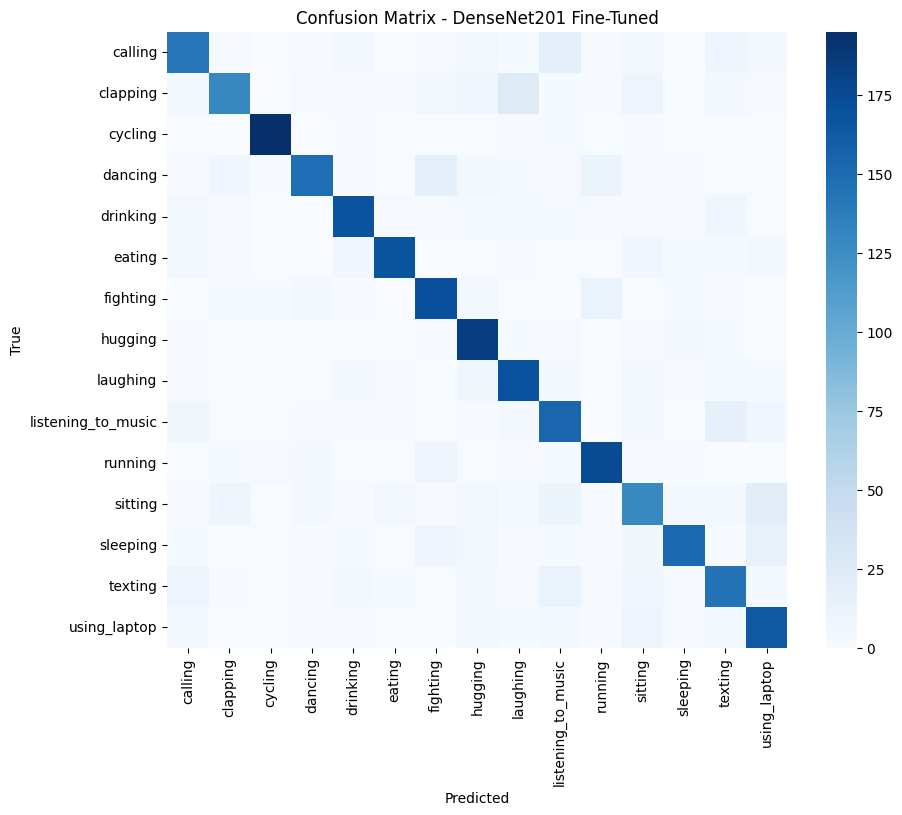

In [ ]:

# 8. Predictions + Confusion Matrix

y_true = test_generator.classes # Get True Labels
y_pred = np.argmax(model.predict(test_generator), axis=1) # Get Predicted Labels

print("\nClassification Report:\n") # Print precision, recall, and F1 for each class
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred) # confusion matrix compares actual vs predicted classes.
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix - DenseNet201 Fine-Tuned")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

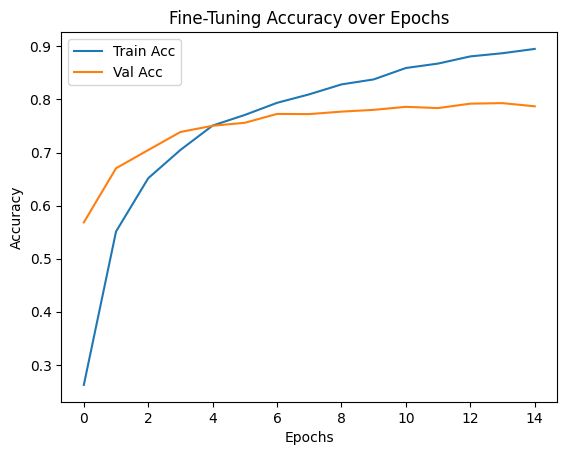

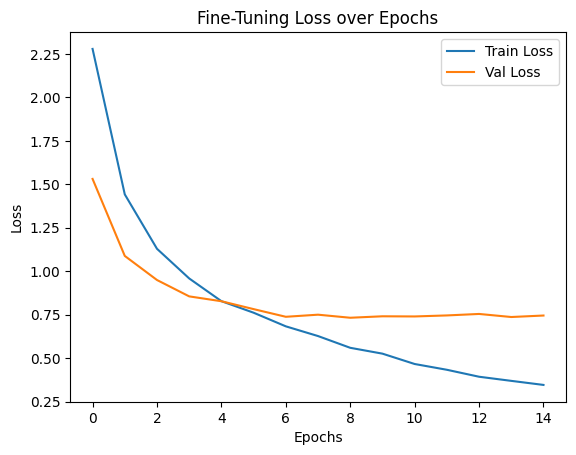

In [ ]:

# 9. Training Curves

plt.plot(history_finetune.history['accuracy'], label='Train Acc') # model accuracy on training data each epoch.
plt.plot(history_finetune.history['val_accuracy'], label='Val Acc') # accuracy on unseen validation data each epoch.
plt.title("Fine-Tuning Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title("Fine-Tuning Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()